# Obtaining the different properties of CADs

In this notebook, we compute:

- differences in tokens between originals and CADs
- semantic similarity between originals and CADs
- type of edit

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_context('talk')


DESIGNEDDATAPATH = '../designed_data/cad/'

In [2]:
constructs = ['sexism', 'hatespeech']
construct = 'sexism'
construct = 'hatespeech'

In [3]:
# emulate_data = pd.read_csv('../../socialCAD_/data/data/hatespeech/train/paired_adv_cad_10.csv', sep = '\t')
paired_data = {}
for construct in constructs:
    paired_data[construct] = pd.read_csv('../data/data/data/%s/train/paired_cads_mixed.csv' %construct,
                                  sep = '\t')
    ## let's drop these cases where the manual CAD label is the same as the original CAD label
    paired_data[construct] = paired_data[construct][paired_data[construct]['original_label'] \
                                                    != paired_data[construct]['counterfactual_label']].reset_index()

In [4]:
cad_types = ['counterfactual', 'polyjuice', 'chatgpt', 'flant5', 'mixed_cad']

In [5]:
for construct in constructs:
    print(construct)
    print(paired_data[construct].groupby('original_label').size())
    for cad_type in cad_types:
        print(paired_data[construct].groupby(cad_type+'_label').size())
    print()

sexism
original_label
non-sexist    1610
sexist        1244
dtype: int64
counterfactual_label
MAR            596
NMAR          1610
non-sexist     648
dtype: int64
polyjuice_label
MAR            553
NMAR          1610
non-sexist     691
dtype: int64
chatgpt_label
MAR              2
NMAR          1610
non-sexist    1242
dtype: int64
flant5_label
MAR            103
NMAR          1610
non-sexist    1141
dtype: int64
mixed_cad_label
MAR            317
NMAR          1610
non-sexist     927
dtype: int64

hatespeech
original_label
hate        6503
not hate    5759
dtype: int64
counterfactual_label
hate        5759
not hate    6503
dtype: int64
polyjuice_label
MAR         5604
hate        3277
not hate    3381
dtype: int64
chatgpt_label
MAR          174
hate        5679
not hate    6409
dtype: int64
flant5_label
MAR         1067
hate        5130
not hate    6065
dtype: int64
mixed_cad_label
MAR         1704
hate        4946
not hate    5612
dtype: int64



## Property 1: edit distance

In [6]:
def text_len(texts, labels, char_len = True, ed = True):
    text_lens = []
    if not char_len:
        for n, text in enumerate(texts):
            if type(text) != str or labels[n] in ['MAR', 'NMAR']:
                text_lens.append(np.nan)
            else:
                text_lens.append(len(text.split(' '))) # TODO: try a tweet tokenizer? https://stackoverflow.com/questions/61919670/how-nltk-tweettokenizer-different-from-nltk-word-tokenize
        return text_lens
    for n, text in enumerate(texts):
        if type(text) != str or labels[n] in ['MAR', 'NMAR']:
            text_lens.append(np.nan)
        else:
            text_lens.append(len(text))
        
    return text_lens

In [7]:
categories = ['original'] + cad_types

In [8]:
for construct in constructs:
    for category in categories:
        paired_data[construct][category+'_len'] = text_len(paired_data[construct][category+'_text'].values,
                                                           paired_data[construct][category+'_label'].values,
                                                           char_len = False)

In [9]:
for construct in constructs:
    print(paired_data[construct][[category+'_len' for category in categories]].isna().sum())
    print()

original_len             0
counterfactual_len    2206
polyjuice_len         2163
chatgpt_len           1612
flant5_len            1713
mixed_cad_len         1927
dtype: int64

original_len             0
counterfactual_len       0
polyjuice_len         5604
chatgpt_len            174
flant5_len            1067
mixed_cad_len         1704
dtype: int64



In [10]:
for construct in constructs:
    print(construct)
    print(paired_data[construct][[category+'_len' for category in categories]].mean())
    print(paired_data[construct][[category+'_len' for category in categories]].median())
    print(paired_data[construct][[category+'_len' for category in categories]].std())
    print()

sexism
original_len          15.368605
counterfactual_len    15.766975
polyjuice_len         14.544139
chatgpt_len           15.938808
flant5_len            14.643295
mixed_cad_len         15.104639
dtype: float64
original_len          15.0
counterfactual_len    16.0
polyjuice_len         14.0
chatgpt_len           15.0
flant5_len            14.0
mixed_cad_len         14.0
dtype: float64
original_len          6.212394
counterfactual_len    5.758109
polyjuice_len         5.862359
chatgpt_len           6.943617
flant5_len            5.643178
mixed_cad_len         6.102336
dtype: float64

hatespeech
original_len          22.401810
counterfactual_len    24.412168
polyjuice_len         16.965005
chatgpt_len           23.658173
flant5_len            21.300134
mixed_cad_len         22.444497
dtype: float64
original_len          14.0
counterfactual_len    16.0
polyjuice_len         11.0
chatgpt_len           17.0
flant5_len            13.0
mixed_cad_len         15.0
dtype: float64
original_len

In [11]:
for construct in constructs:
    paired_data[construct]['original-counterfactual'] = paired_data[construct]["original_len"] - paired_data[construct]["counterfactual_len"]
    paired_data[construct]['counterfactual-original'] = paired_data[construct]["counterfactual_len"] - paired_data[construct]["original_len"]
    paired_data[construct]['original-chatgpt'] = paired_data[construct]["original_len"] - paired_data[construct]["chatgpt_len"]
    paired_data[construct]['original-polyjuice'] = paired_data[construct]["original_len"] - paired_data[construct]["polyjuice_len"]
    paired_data[construct]['chatgpt-original'] = paired_data[construct]["chatgpt_len"] - paired_data[construct]["original_len"]
    paired_data[construct]['original-flant5'] = paired_data[construct]["original_len"] - paired_data[construct]["flant5_len"]
    paired_data[construct]['original-mixed_cad'] = paired_data[construct]["original_len"] - paired_data[construct]["mixed_cad_len"]

In [12]:
for construct in constructs:
    print(construct)
    print(paired_data[construct][['original-%s' %category for category in cad_types]].mean())
    print(paired_data[construct][['original-%s' %category for category in cad_types]].median())
    print(paired_data[construct][['original-%s' %category for category in cad_types]].std())
    print()

sexism
original-counterfactual    0.513889
original-polyjuice         0.199711
original-chatgpt          -0.413849
original-flant5            0.740578
original-mixed_cad         0.378641
dtype: float64
original-counterfactual    0.0
original-polyjuice         0.0
original-chatgpt           0.0
original-flant5            0.0
original-mixed_cad         0.0
dtype: float64
original-counterfactual    1.543734
original-polyjuice         1.721324
original-chatgpt           5.500222
original-flant5            2.138866
original-mixed_cad         3.363522
dtype: float64

hatespeech
original-counterfactual   -2.010357
original-polyjuice         0.186242
original-chatgpt          -1.132611
original-flant5            1.204377
original-mixed_cad        -0.693503
dtype: float64
original-counterfactual   -1.0
original-polyjuice         0.0
original-chatgpt          -2.0
original-flant5            0.0
original-mixed_cad         0.0
dtype: float64
original-counterfactual     5.623796
original-polyjuice 

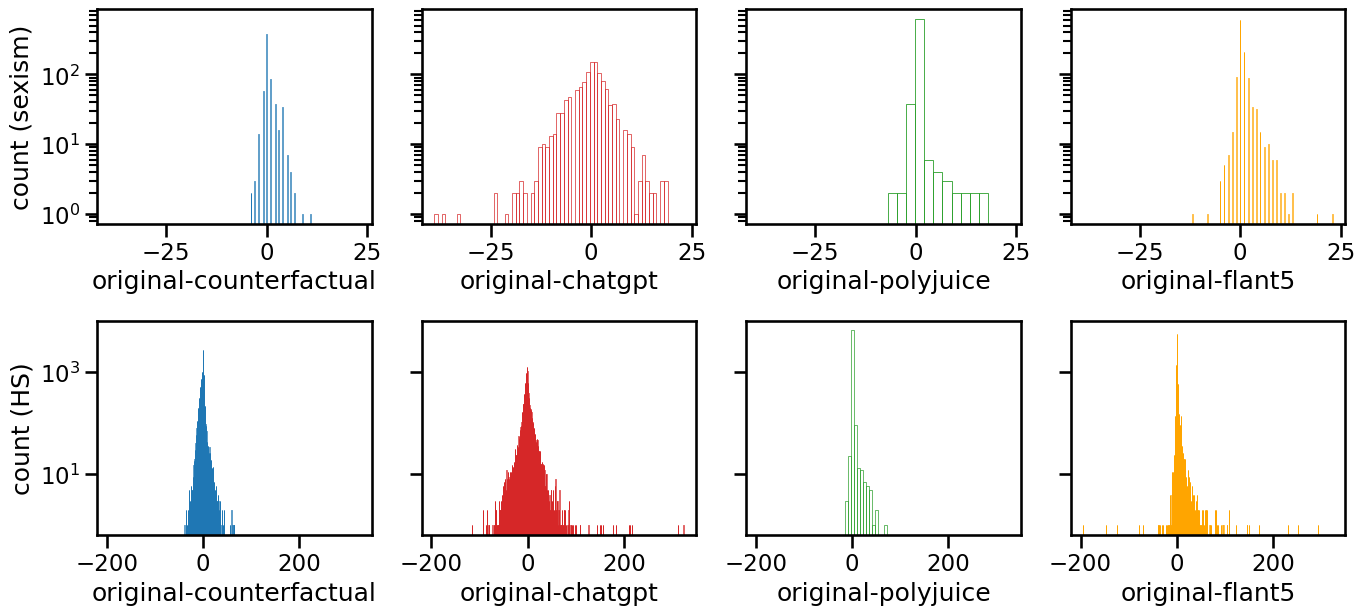

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=4,
                        figsize = (14, 6.5),
                        sharex = 'row',
                        sharey = 'row'
                       )
for n, construct in enumerate(constructs):
    data = paired_data[construct]
    sns.histplot(data['original-counterfactual'], fill=False, label = 'orig-manual', ax = ax[n][0])
    sns.histplot(data['original-chatgpt'], color = 'tab:red', fill=False, label = 'orig-gpt', ax = ax[n][1])
    sns.histplot(data['original-polyjuice'], color = 'tab:green', fill=False, label = 'orig-poly', ax = ax[n][2])
    sns.histplot(data['original-flant5'], color = 'orange', fill=False, label = 'orig-flant5', ax = ax[n][3])
    
    
    #ax[n][0].set_xlabel('token differences')
    #ax[n][0].set_title(construct)
    #ax[n][0].legend()
    # ax[n].set_yscale('log')
    
ax[0][0].set_ylabel('count (sexism)')
ax[1][0].set_ylabel('count (HS)')
ax[0][0].set_yscale('log')
ax[1][0].set_yscale('log')


plt.tight_layout()
# plt.savefig('../results/figures/token_diffs.pdf')

In [14]:
# ! pip install string2string

In [15]:
# # Let's create a Levenshtein edit distance class instance, with the default (unit cost) weights, from the distance module
# from string2string.distance import LevenshteinEditDistance
# edit_dist = LevenshteinEditDistance()

# # Let's also create a Tokenizer class instance with the default word delimiter (i.e., space)
# from string2string.misc import Tokenizer
# tokenizer = Tokenizer(word_delimiter=' ')

# # Let's create two strings
# text1 = "The quick brown fox jumps over the lazy dog"
# text2 = "The kuack brown box jumps over the lazy dog"

# # Get the edit distance between them at the character level
# edit_dist_score  = edit_dist.compute(text1, text2)

# print(f"Edit distance between these two texts at the character level is {edit_dist_score}")
# # Edit distance between these two texts at the character level is 3.0

# # Tokenize the two texts
# text1_tokens = tokenizer.tokenize(text1)
# text2_tokens = tokenizer.tokenize(text2)

# # Get the distance between them at the word level
# edit_dist_score  = edit_dist.compute(text1_tokens, text2_tokens)

# print(f"Edit distance between these two texts at the word level is {edit_dist_score}")
# # Edit distance between these two texts at the word level is 2.0

## Property 2: semantic similarity

In [16]:
# ! pip install sentence_transformers
# ! pip install simpletransformers

In [17]:
from embed_docs import embed, embed_df, embed_one_shot
from find_sim import find_similarity, find_multi_similarity
from sentence_transformers import SentenceTransformer, util

tokenize = True
token_flag = 'tokenized' if tokenize else 'nontokenized'
text_ = 'sent' if tokenize else 'body'

In [18]:
## do once and save

# for construct in constructs:
#     print(construct)
#     for text_category in categories:
#         paired_data[construct]['%s_embeddings' %text_category] = embed_df(paired_data[construct].copy(), filename = '',
#                          embedding_type = 'sbert',
#                          save = False,
#                          #tokenize = True,
#                          id_field = 'original_id',
#                          text_field = '%s_text' %text_category,
#                          sep = '\t')
#         print()
#     print()
    
# with open('../results/intermediate/paired_cads_mixed_embeddings.pickle', 'wb') as handle:
#     pickle.dump(paired_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../results/intermediate/paired_cads_mixed_embeddings.pickle', 'rb') as handle:
    paired_data = pickle.load(handle)

In [19]:
paired_data['hatespeech']['original_id'].values#[paired_data['hatespeech']['original_id'] == 10528]

array([19637, 19638, 19640, ..., 47718, 53779, 53783], dtype=int64)

In [20]:
pairs = { 
          'original-counterfactual' : ['original', 'counterfactual'],
          'original-polyjuice' : ['original', 'polyjuice'],
          'original-ChatGPT' : ['original', 'chatgpt'],
          'original-FlanT5' : ['original', 'flant5'],
          'original-mixed' : ['original', 'mixed_cad'],
         
#           'counterfactual-polyjuice' : ['counterfactual', 'polyjuice'],
#           'counterfactual-ChatGPT' : ['counterfactual', 'chatgpt'],
#           'counterfactual-FlanT5' : ['counterfactual', 'flant5'],
          
#           'polyjuice-ChatGPT' : ['polyjuice', 'chatgpt'],
#           'polyjuice-FlanT5' : ['polyjuice', 'chatgpt'],
         
#           'ChatGPT-FlanT5' : ['chatgpt', 'flant5'],
          
         }

In [21]:
cosine_scores = {}

for construct in constructs:
    cosine_scores[construct] = {}
    
    for pair, pair_list in pairs.items():
        data = paired_data[construct].dropna(subset = [pair_list[1]+'_text'])
        data = data[~data[pair_list[1]+'_label'].isin(['MAR', 'NMAR'])].reset_index() # remove missing CADs
        
        cosine_scores[construct][pair] = util.cos_sim(data[pair_list[0] + '_embeddings'],
                                                       data[pair_list[1] + '_embeddings'])
        print(pair, len(data), len(cosine_scores[construct][pair]))
    print()

original-counterfactual 648 648
original-polyjuice 691 691
original-ChatGPT 1244 1244
original-FlanT5 1141 1141
original-mixed 869 869

original-counterfactual 12262 12262
original-polyjuice 6658 6658
original-ChatGPT 12085 12085
original-FlanT5 11195 11195
original-mixed 10594 10594



In [22]:
for construct in constructs:
    # print(construct, len(cosine_scores[construct]['original-original']))
    # print(sum([i-1 for i in cosine_scores[construct]['original-original'].sum(axis=0)]) / (len(cosine_scores[construct]['original-original']) * len(cosine_scores[construct]['original-original'])))
    print(sum(cosine_scores[construct]['original-counterfactual'].diagonal()) / len(cosine_scores[construct]['original-counterfactual']))
    print(sum(cosine_scores[construct]['original-polyjuice'].diagonal()) / len(cosine_scores[construct]['original-polyjuice']))
    print(sum(cosine_scores[construct]['original-ChatGPT'].diagonal()) / len(cosine_scores[construct]['original-ChatGPT']))
    print(sum(cosine_scores[construct]['original-FlanT5'].diagonal()) / len(cosine_scores[construct]['original-FlanT5']))
    print()

tensor(0.8096)
tensor(0.8988)
tensor(0.6703)
tensor(0.9044)

tensor(0.7516)
tensor(0.8626)
tensor(0.6763)
tensor(0.9012)



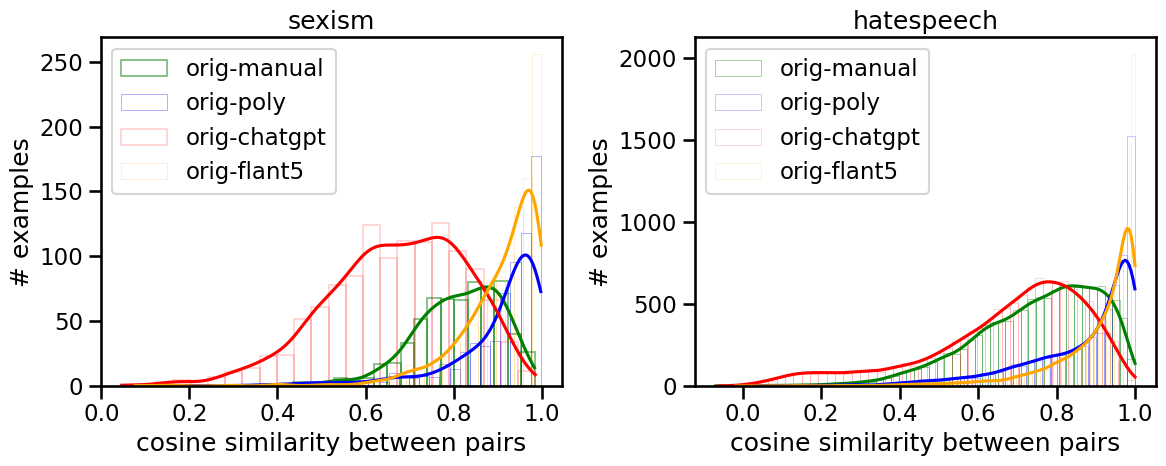

In [23]:
fig, ax1 = plt.subplots(nrows=1, ncols=2,
                        figsize = (12, 5),
                        sharex = False,
                       # sharey = True
                       )
for n, perplexity in enumerate(constructs):
    sns.histplot(cosine_scores[perplexity]['original-counterfactual'].diagonal(), ax = ax1[n],
                 alpha = 0.5, color = 'green', label = 'orig-manual', kde = True, fill = False)
    sns.histplot(cosine_scores[perplexity]['original-polyjuice'].diagonal(), ax = ax1[n],
                 alpha = 0.3, label = 'orig-poly', color = 'blue', kde = True, fill = False)
    sns.histplot(cosine_scores[perplexity]['original-ChatGPT'].diagonal(), ax = ax1[n],
                 alpha = 0.2, label = 'orig-chatgpt', color = 'red', kde = True, fill = False)
    sns.histplot(cosine_scores[perplexity]['original-FlanT5'].diagonal(), ax = ax1[n],
                 alpha = 0.2, label = 'orig-flant5', color = 'orange', kde = True, fill = False)
    
    ax1[n].set_ylabel('# examples')
    ax1[n].set_xlabel('cosine similarity between pairs')
    ax1[n].legend()
    ax1[n].set_title(perplexity)
    
plt.tight_layout()
# plt.savefig('../results/figures/embedding_analysis.pdf')
plt.show()

## Property 3: type of change

In [24]:
import difflib
import string

original = 'women shouldn\'t commentate on football matches'
edited = 'AI shouldn\'t commentate on football matches'

In [25]:
# initiate the Differ object
d = difflib.Differ()

# calculate the difference between the two texts
diff = d.compare(original.split(), edited.split())

additions = []
deletions = []
for token in diff:
    print(token)
    if token.startswith("+"):
        additions.append(token[2:])
    if token.startswith("-"):
        deletions.append(token[2:])
        
additions, deletions   

def find_diff(original, edited):
    """
    given a pair of sentences, return the tokens that have been changed (subsituted, added, or deleted)
    """
    if type(edited) != str:
        return np.nan
    result = {}
    
    d = difflib.Differ()
    
    original = original.translate(str.maketrans('', '', string.punctuation))
    edited = edited.translate(str.maketrans('', '', string.punctuation))

    # calculate the difference between the two texts
    diff = d.compare(original.split(), edited.split())

    # output the result
    additions = []
    deletions = []
    for token in diff:
        # additions
        if token.startswith("+"):
            additions.append(token[2:])
        if token.startswith("-"):
            deletions.append(token[2:])
        
    result['additions'] = additions
    result['deletions'] = deletions   
    
    return result

- women
+ AI
  shouldn't
  commentate
  on
  football
  matches


In [26]:
import ast

for construct in constructs:
    for category in cad_types:
        paired_data[construct]['%s_diff' %category] = [find_diff(row['original_text'], row[category + '_text']) for n,
                                           row in paired_data[construct].iterrows()]

In [27]:
paired_data[construct].columns

Index(['index', 'Unnamed: 0', 'original_id', 'counterfactual_id',
       'original_text', 'counterfactual_text', 'original_label',
       'counterfactual_label', 'diff', 'negation_additions',
       'negation_deletions', 'affect word_additions', 'affect word_deletions',
       'gender word_additions', 'gender word_deletions',
       'identity word_additions', 'identity word_deletions',
       'hedges_additions', 'hedges_deletions', 'hate words_additions',
       'hate words_deletions', 'polyjuice', 'polyjuice_label', 'chatgpt',
       'chatgpt_label', 'flant5', 'flant5_label', 'polyjuice_text',
       'chatgpt_text', 'flant5_text', 'mixed_cad_text', 'mixed_cad_type',
       'mixed_cad_label', 'original_len', 'counterfactual_len',
       'polyjuice_len', 'chatgpt_len', 'flant5_len', 'mixed_cad_len',
       'original-counterfactual', 'counterfactual-original',
       'original-chatgpt', 'original-polyjuice', 'chatgpt-original',
       'original-flant5', 'original-mixed_cad', 'original_em

### Use lexicons to categorize diffs

In [28]:
with open('../data/data/lexica.pkl', 'rb') as handle:
    lexicons = pickle.load(handle)

diff_types = lexicons.keys()
directions = ['additions', 'deletions']

# diff types are negation, affect word / sentiment flip, gender word change, identity word change 
def classify_diff(diff, direction = 'additions', diff_type = 'negation'):
    if type(diff) == float:
        return np.nan
    if len(set(diff[direction]).intersection(set(lexicons[diff_type]))) > 0:
        return True
    return np.nan

In [29]:
for lexicon in lexicons:
    print(lexicon, len(set(lexicons[lexicon])))

negation 19
affect word 6786
gender word 409
identity word 17
hedges 76
hate words 371


merge hate and identity words

In [30]:
lexicons['identity word'] = list(set(list(lexicons['identity word']) + list(lexicons['hate words'])))
lexicons.pop('hate words')

['papists',
 'Zionazis',
 'muzzy',
 'globalists',
 'higgers',
 'muzzies',
 'muzzie',
 'papist',
 'Christ killers',
 'Zionazi',
 'Orangies',
 'soup taker',
 'heebs',
 'hymie',
 'camel fuckers',
 'hooknose',
 'clamheads',
 'pisslam',
 'carrot snappers',
 'holohoax',
 'camel fucker',
 'Fenian',
 'mussie',
 'derka derka',
 'hooknoses',
 'gews',
 'heeb',
 'hebros',
 'mussies',
 'musla',
 'oven dodgers',
 'Fenians',
 'sand monkeys',
 'Christ killer',
 'sand monkey',
 'soup takers',
 'higger',
 'mackerel snappers',
 'papists',
 'muzzie',
 'Zionazi',
 'Zionazis',
 'muzzies',
 'globalists',
 'heeb',
 'Jihadi',
 'higgers',
 'Christ killers',
 'ziojews',
 'muzzrat',
 'muzzrats',
 'soup takers',
 'hebros',
 'muzzy',
 'camel fuckers',
 'muslamic',
 'pisslam',
 'sand monkeys',
 'Gerudos',
 'hebes',
 'khazars',
 'hymie',
 'heebs',
 'papist',
 'Christ killer',
 'muzzie',
 'Zionazi',
 'Jihadi',
 'camel fucker',
 'hymie',
 'Christ killer',
 'oven dodger',
 'khazar',
 'higger',
 'hebro',
 'heeb',
 'muzzi

In [31]:
for lexicon in lexicons:
    print(lexicon, len(set(lexicons[lexicon])))

negation 19
affect word 6786
gender word 409
identity word 387
hedges 76


In [32]:
for construct in constructs:
    for diff_type in diff_types:
        for direction in directions:
            for category in cad_types:
                paired_data[construct][category + diff_type + "_" + direction] = [classify_diff(row['%s_diff' %category],
                                                                                         direction, diff_type) \
                                                           for n, row in paired_data[construct].iterrows()]

In [33]:
types = ['negation_additions',
       'negation_deletions', 'affect word_additions', 'affect word_deletions',
       'gender word_additions', 'gender word_deletions',
       'identity word_additions', 'identity word_deletions',
        'hedges_additions', 'hedges_deletions',
        #'hate words_additions', 'hate words_deletions'
        ]

In [34]:
cad_types = ['counterfactual', 'polyjuice', 'chatgpt', 'flant5']

In [35]:
dist_list = {}

for construct in constructs:
    dist_list[construct] = {}
    for category in cad_types:
        data = paired_data[construct].dropna(subset = [category + '_text'])
        data = data[~data[category + '_label'].isin(['MAR', 'NMAR'])].reset_index() # remove missing CADs
        dist_dict = {}
        
        dist_dict['total'] = len(data)
        total = len(data)
        
        print("total examples of " + construct + ": " + str(total))
        
        for diff_type in types:
            dist_dict[diff_type] = "%.3f"  %(len(data[data[category + diff_type] == True])/total)
            print(diff_type + ": " + str(len(data[data[category + diff_type] == True])/total))
        print()
        dist_list[construct][category] = dist_dict

total examples of sexism: 648
negation_additions: 0.013888888888888888
negation_deletions: 0.08487654320987655
affect word_additions: 0.1388888888888889
affect word_deletions: 0.041666666666666664
gender word_additions: 0.023148148148148147
gender word_deletions: 0.7901234567901234
identity word_additions: 0.044753086419753084
identity word_deletions: 0.12191358024691358
hedges_additions: 0.010802469135802469
hedges_deletions: 0.004629629629629629

total examples of sexism: 691
negation_additions: 0.010130246020260492
negation_deletions: 0.020260492040520984
affect word_additions: 0.16642547033285093
affect word_deletions: 0.14616497829232997
gender word_additions: 0.11432706222865413
gender word_deletions: 0.14327062228654125
identity word_additions: 0.010130246020260492
identity word_deletions: 0.017366136034732273
hedges_additions: 0.013024602026049204
hedges_deletions: 0.02170767004341534

total examples of sexism: 1244
negation_additions: 0.21061093247588425
negation_deletions: 0.

In [36]:
pd.DataFrame(dist_list['sexism'])

,counterfactual,polyjuice,chatgpt,flant5
total,648,691,1244,1141
negation_additions,0.014,0.010,0.211,0.048
negation_deletions,0.085,0.020,0.181,0.060
affect word_additions,0.139,0.166,0.490,0.145
affect word_deletions,0.042,0.146,0.436,0.170
gender word_additions,0.023,0.114,0.118,0.209
gender word_deletions,0.790,0.143,0.780,0.252
identity word_additions,0.045,0.010,0.031,0.020
identity word_deletions,0.122,0.017,0.093,0.025
hedges_additions,0.011,0.013,0.244,0.021


In [37]:
pd.DataFrame(dist_list['hatespeech'])

,counterfactual,polyjuice,chatgpt,flant5
total,12262,6658,12085,11195
negation_additions,0.111,0.006,0.223,0.087
negation_deletions,0.065,0.007,0.184,0.061
affect word_additions,0.455,0.240,0.815,0.251
affect word_deletions,0.273,0.245,0.616,0.323
gender word_additions,0.135,0.062,0.093,0.048
gender word_deletions,0.109,0.051,0.174,0.051
identity word_additions,0.132,0.023,0.089,0.031
identity word_deletions,0.128,0.060,0.171,0.047
hedges_additions,0.092,0.015,0.225,0.020


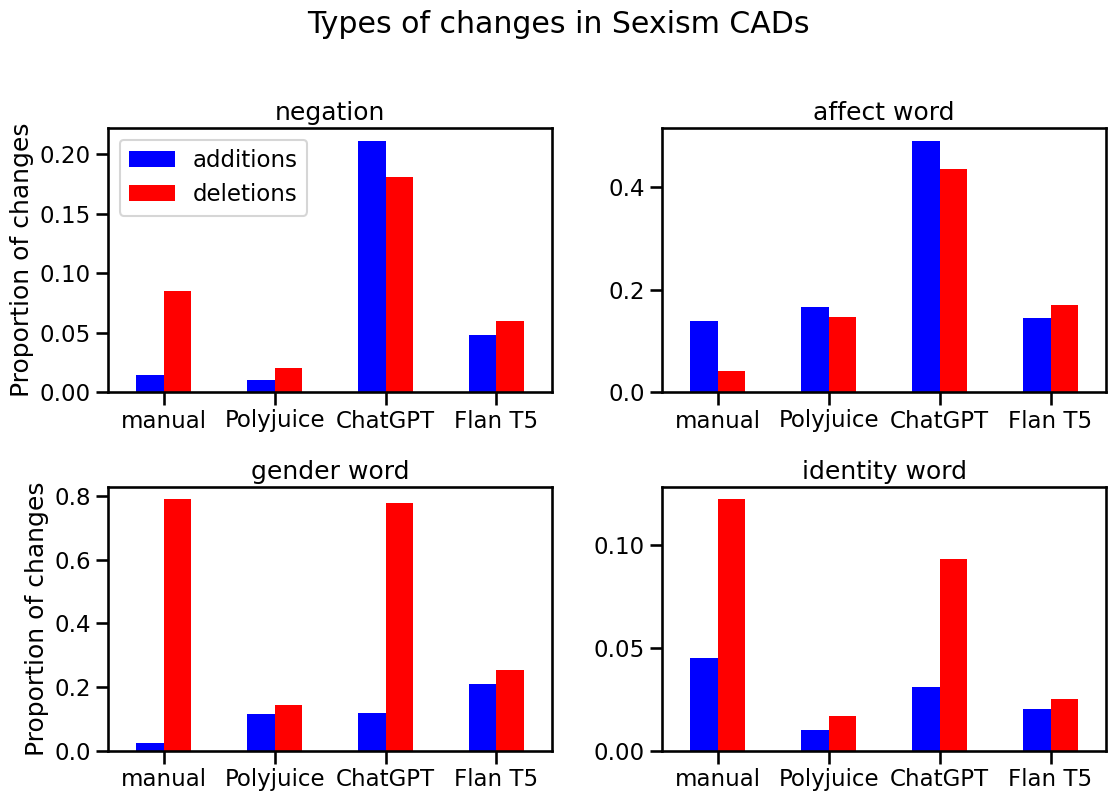

In [38]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (11.5, 8))

result_df = pd.DataFrame(dist_list['sexism'])
result_df.columns = ['manual', 'Polyjuice', 'ChatGPT', 'Flan T5']

for n, category in enumerate(['negation', 'affect word', 'gender word', 'identity word']):
    i = n // 2
    j = n % 2
    result_df.T[['%s_additions' %category, '%s_deletions' %category]].astype(float).plot(kind = 'bar', ax = ax[i][j],
                                                                                         color = ['blue', 'red'])
    ax[i][j].set_xticklabels(result_df.columns, rotation=0)
    ax[i][j].set_title(category)
    if i != 0 or j != 0:
        ax[i][j].get_legend().remove()
    else:
        ax[i][j].legend(labels=['additions', 'deletions'])
        
    if j == 0:
        ax[i][j].set_ylabel('Proportion of changes')

plt.suptitle('Types of changes in Sexism CADs', y=1.01)
plt.tight_layout()
plt.savefig('../results/figures/sexism_diff_types.pdf', bbox_inches = "tight")

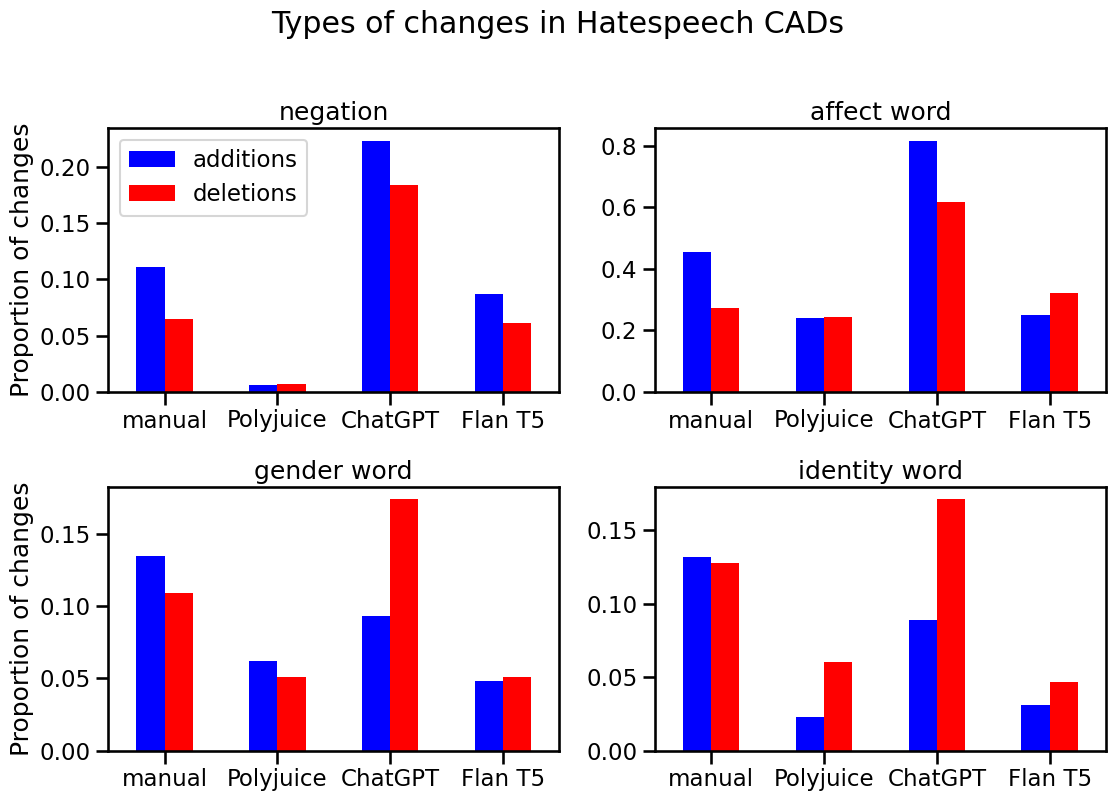

In [39]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (11.5, 8))

result_df = pd.DataFrame(dist_list['hatespeech'])
result_df.columns = ['manual', 'Polyjuice', 'ChatGPT', 'Flan T5']

for n, category in enumerate(['negation', 'affect word', 'gender word', 'identity word']):
    i = n // 2
    j = n % 2
    result_df.T[['%s_additions' %category, '%s_deletions' %category]].astype(float).plot(kind = 'bar', ax = ax[i][j],
                                                                                         color = ['blue', 'red'])
    ax[i][j].set_xticklabels(result_df.columns, rotation=0)
    ax[i][j].set_title(category)
    if i != 0 or j != 0:
        ax[i][j].get_legend().remove()
    else:
        ax[i][j].legend(labels=['additions', 'deletions'])
        
    if j == 0:
        ax[i][j].set_ylabel('Proportion of changes')

plt.suptitle('Types of changes in Hatespeech CADs', y=1.01)
plt.tight_layout()
plt.savefig('../results/figures/hatespeech_diff_types.pdf', bbox_inches = "tight")

### Save the properties for v-info analysis

In [40]:
### compute the cosine similarity again even with NaNs
cosine_scores = {}

for construct in constructs:
    cosine_scores[construct] = {}
    
    for pair, pair_list in pairs.items():
        paired_data[construct][pair.lower() + '_cs'] = util.cos_sim(paired_data[construct][pair_list[0] + '_embeddings'],
                                                       paired_data[construct][pair_list[1] + '_embeddings']).diagonal()
        print(pair, len(paired_data[construct][pair.lower() + '_cs']))
    print()

original-counterfactual 2854
original-polyjuice 2854
original-ChatGPT 2854
original-FlanT5 2854
original-mixed 2854

original-counterfactual 12262
original-polyjuice 12262
original-ChatGPT 12262
original-FlanT5 12262
original-mixed 12262



In [41]:
ids = ['original_id'] # 1

texts = [category + '_text' for category in categories] # 6
labels = [category + '_label' for category in categories] # 6

len_features = ['original-counterfactual',
 'original-chatgpt',
 'original-polyjuice',
 'original-flant5',
 'original-mixed_cad'] # 5

semantic_sim_features = [pair.lower() + '_cs' for pair, _ in pairs.items()] # 5

edit_type_features = ['counterfactualnegation_additions',
 'polyjuicenegation_additions',
 'chatgptnegation_additions',
 'flant5negation_additions',
 'mixed_cadnegation_additions',
 'counterfactualnegation_deletions',
 'polyjuicenegation_deletions',
 'chatgptnegation_deletions',
 'flant5negation_deletions',
 'mixed_cadnegation_deletions',
 'counterfactualaffect word_additions',
 'polyjuiceaffect word_additions',
 'chatgptaffect word_additions',
 'flant5affect word_additions',
 'mixed_cadaffect word_additions',
 'counterfactualaffect word_deletions',
 'polyjuiceaffect word_deletions',
 'chatgptaffect word_deletions',
 'flant5affect word_deletions',
 'mixed_cadaffect word_deletions',
 'counterfactualgender word_additions',
 'polyjuicegender word_additions',
 'chatgptgender word_additions',
 'flant5gender word_additions',
 'mixed_cadgender word_additions',
 'counterfactualgender word_deletions',
 'polyjuicegender word_deletions',
 'chatgptgender word_deletions',
 'flant5gender word_deletions',
 'mixed_cadgender word_deletions',
 'counterfactualidentity word_additions',
 'polyjuiceidentity word_additions',
 'chatgptidentity word_additions',
 'flant5identity word_additions',
 'mixed_cadidentity word_additions',
 'counterfactualidentity word_deletions',
 'polyjuiceidentity word_deletions',
 'chatgptidentity word_deletions',
 'flant5identity word_deletions',
 'mixed_cadidentity word_deletions'
                     ]

In [42]:
all_features = ids +  texts + labels + len_features + semantic_sim_features + edit_type_features + ['mixed_cad_type']
len(ids), len(texts), len(labels), len(len_features), len(semantic_sim_features), len(edit_type_features)

(1, 6, 6, 5, 5, 40)

In [43]:
properties = {}
for construct in constructs:
    properties[construct] = paired_data[construct][all_features]

In [44]:
# with open('../results/intermediate/paired_cads_mixed_rq2_properties.pickle', 'wb') as handle:
#     pickle.dump(properties, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../results/intermediate/paired_cads_mixed_rq2_properties.pickle', 'rb') as handle:
    properties = pickle.load(handle)

<Axes: ylabel='Frequency'>

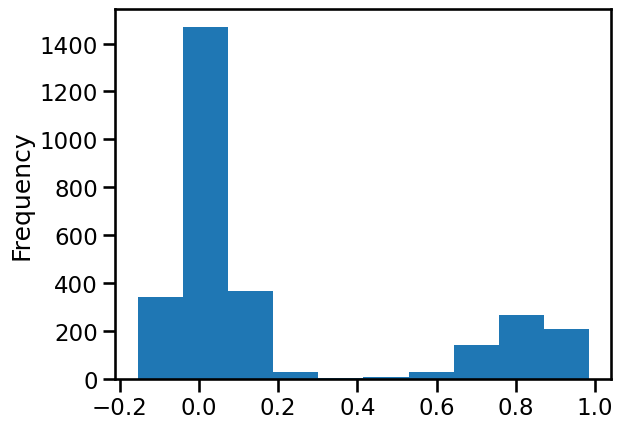

In [45]:
properties['sexism']['original-counterfactual_cs'].plot(kind = 'hist')